# <b>Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce | Apparel
---



<b>Objectives</b>
- Product owner's perspective: 
  - Quality improvement |
  - Gap analysis | same product different maker?
  - Reputation management
- Investor's perspective: 
  - which product owners improve over time
- Consumer perspective
  - Influencial posts

- ML Practice | Inferrential analysis for positive or negative feedback on products in social media product  


---
Notes: 
* #todo : means to check or come back to the code

<b>Understanding the Dataset</b>

* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier (can be used to aggregatereviews for the same product).
*product_title     : Title of the product.
*product_category  : Broad product category.
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

https://www.tensorflow.org/datasets/catalog/amazon_us_reviews

#### Importing libaries and Apparel dataset

In [1]:
# (1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  14.4M      0  0:00:42  0:00:42 --:--:-- 14.1M


In [3]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

In [4]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv  sample_data


In [5]:
# (3.b) Explore data (see what is categorial and numerical)

In [52]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=100000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        100000 non-null  object
 1   customer_id        100000 non-null  int64 
 2   review_id          100000 non-null  object
 3   product_id         100000 non-null  object
 4   product_parent     100000 non-null  int64 
 5   product_title      100000 non-null  object
 6   product_category   100000 non-null  object
 7   star_rating        100000 non-null  int64 
 8   helpful_votes      100000 non-null  int64 
 9   total_votes        100000 non-null  int64 
 10  vine               100000 non-null  object
 11  verified_purchase  100000 non-null  object
 12  review_headline    100000 non-null  object
 13  review_body        99947 non-null   object
 14  review_date        99997 non-null   object
dtypes: int64(5), object(10)
memory usage: 11.4+ MB


In [7]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
299995,US,11794308,RGL12VWDODBGF,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,They would be a decent pair of scrubs for the ...,They would be a decent pair of scrubs for the ...,2015-08-02
299996,US,10525470,R1D9YUDSAF43Z9,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,2,2,N,Y,Fit?,I want to start by saying I love the style. Th...,2015-06-08
299997,US,11785074,R38HJNAO7LK722,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,1,1,1,N,Y,One Star,"They were too small, and it was difficult to r...",2015-05-12
299998,US,24098870,R3TT5VMKGA7MG6,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,4,0,0,N,Y,For the price these scrubs are great! The top ...,For the price these scrubs are great! The top ...,2015-08-31
299999,US,19988435,R1V5G2V0O5QXDT,B00RNT940S,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,Three Stars,good quality but it's quite large for me,2015-08-26


###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [59]:
# Checking unique values of each row in all columns
n = df.nunique(axis=0)
print(
    "Total number of rows in this data set is:{}\nNumber of unique values in each column for in this dataset is:\n"
    .format(len(df)), n)
# outcome --> drop marketplace-category-reviewID
# outcome --> bool vine verified purchase

Total number of rows in this data set is:100000
Number of unique values in each column for in this dataset is:
 marketplace               1
customer_id           85149
review_id            100000
product_id            66229
product_parent        41084
product_title         39656
product_category          1
star_rating               5
helpful_votes           206
total_votes             215
vine                      2
verified_purchase         2
review_headline       53335
review_body           92599
review_date             173
dtype: int64


In [60]:
# Cleaning
# (1) Drop irrelevant info: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])
 
# (4) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

# (5) Drop the rows where there are no reviews and no review dates
df.dropna(subset = ['review_body'], inplace = True)
df.dropna(subset = ['review_date'], inplace = True)

#  creating numerical df -> df_num for EDA
#  creating categorical df -> df_cat
cat_list = ['product_parent','product_id','customer_id','product_title','review_body']

df_num = df.drop(cat_list, inplace = False , axis = 1) 
df_cat = df[cat_list]

# Print to see the null rows if any
null_columns=df.columns[df.isnull().any()]
df[df["review_date"].isnull()] #[null_columns] add to tail end to show null columns when that particular colum is null

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date


In [62]:
df.info()
df_cat.info() 
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99944 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        99944 non-null  int64         
 1   product_id         99944 non-null  object        
 2   product_parent     99944 non-null  int64         
 3   product_title      99944 non-null  object        
 4   star_rating        99944 non-null  int64         
 5   helpful_votes      99944 non-null  int64         
 6   total_votes        99944 non-null  int64         
 7   vine               99944 non-null  int64         
 8   verified_purchase  99944 non-null  int64         
 9   review_body        99944 non-null  object        
 10  review_date        99944 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 11.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99944 entries, 0 to 99999
Data columns (total 5 columns)

#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e

In [65]:
print(df['review_body'])

0        ★ these really do work great with some tweakin...
1        favorite for winter. very warm! i love this dr...
2        great socks for the money. nice socks, great c...
3        slick hat! i bought this for my husband and wo...
4        i would do it again! perfect dress and the cus...
                               ...                        
99995                   five stars my girlfriend loved it.
99996                               four stars great shirt
99997                               five stars sweet shirt
99998                            five stars very well made
99999         so great! this was a hit at the baby shower!
Name: review_body, Length: 99944, dtype: object


In [64]:
# Removing the hashtags | Revise - not working #todo
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_mentions(row['product_title']), axis=1)

In [23]:
# Removing the emojis |

# # Reference code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# def remove_emoji(review_body):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

In [24]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [63]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
df['product_title'] = df['product_title'].str.lower()
df['product_title']

0        easy tool stainless steel fruit pineapple core...
1        v28 women cowl neck knit stretchable elasticit...
2        james fiallo men's 12-pairs low cut athletic s...
3        belfry gangster 100% wool stain-resistant crus...
4        jaeden women's beaded spaghetti straps sexy lo...
                               ...                        
99995    cybertela women's nice fish you caught, can.. ...
99996    cybertela women's if you don’t fish i see.. fu...
99997      asgard blacksmith's alliance thor men's t-shirt
99998                      naturana women's mastectomy bra
99999    ah pardon me my good sir i believe i may have ...
Name: product_title, Length: 99944, dtype: object

In [66]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_numbers(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_numbers(row['product_title']), axis=1)

In [67]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df.apply(lambda row: remove_non_ascii(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_non_ascii(row['product_title']), axis=1)

In [68]:
# Removal of punctuation
import re      # Import REGEX
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_punctuation(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_punctuation(row['product_title']), axis=1)


In [69]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [70]:
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date
0,32158956,B01KL6O72Y,24485154,easy tool stainless steel fruit pineapple core...,4,0,0,0,1,really work great tweaking really work great b...,2013-01-14
1,2714559,B01ID3ZS5W,363128556,v women cowl neck knit stretchable elasticity ...,5,1,2,0,1,favorite winter warm love dress absolute favor...,2014-03-04
2,12608825,B01I497BGY,811958549,james fiallo mens pairs low cut athletic sport...,5,0,0,0,1,great socks money nice socks great colors enou...,2015-07-12
3,25482800,B01HDXFZK6,692205728,belfry gangster wool stainresistant crushable...,5,0,0,0,1,slick hat bought husband wow slick hat high qu...,2015-06-03
4,9310286,B01G6MBEBY,431150422,jaeden womens beaded spaghetti straps sexy lon...,5,0,0,0,1,would perfect dress customer service awesome,2015-06-12


### EDA and Feature Engineering

In [55]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id', 'product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

df_num.describe()

,star_rating,helpful_votes,total_votes,vine,verified_purchase
count,299854.000000,299854.000000,299854.000000,299854.000000,299854.000000
mean,3.980694,1.289301,1.528801,0.002294,0.917520
std,1.361413,11.471966,11.939118,0.047846,0.275095
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,1.000000,1.000000,0.000000,1.000000
max,5.000000,3675.000000,3714.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


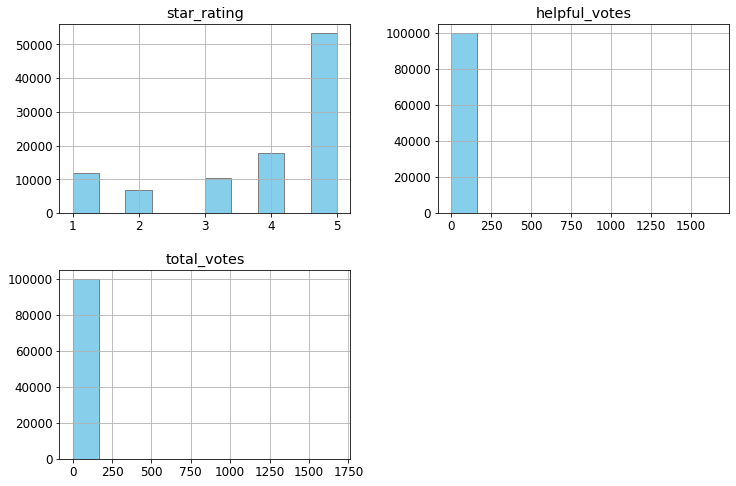

In [56]:
# Check the distribution of the star rating with the DataFrame | reference chart: https://www.datacamp.com/community/tutorials/histograms-matplotlib
# plt.hist(df.star_rating, bins='auto', color = "skyblue", ec='grey')
# plt.gca().set(title='Frequency Histogram | Review Stars |', ylabel='Frequency',xlabel = 'stars',alpha=0.7, rwidth=0.85);
# plt.show()

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df_discriptive.hist(ax=ax, color = "skyblue", ec='grey')
plt.show()

# Clustering per groups of product parent | votes per product parent
# Sentimet (from -ve) most common words for improvement | from (+ve) most common words for gap analysis
# we will need to scale our stars to min max
# then our scaled stars are our sentiment label, and text is the features? 


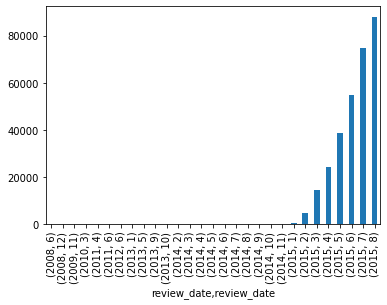

In [ ]:
# Looking at year and month for review | seems we can extra clean outliers outside 2015 #todo
df.star_rating.groupby([df["review_date"].dt.year, df["review_date"].dt.month]).count().plot(kind="bar")

In [ ]:
# Looking at product parent | 
df.product_id.groupby([df["product_parent"],df['star_rating']]).count().plot(kind="bar")

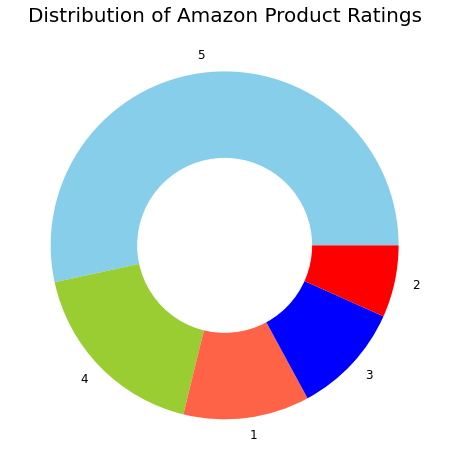

In [57]:
# Distribution of Amazon Product Ratings
ratings = df["star_rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299854 entries, 0 to 299853
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_body  299854 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [71]:
def sentiment(row):
    
    '''This function returns sentiment value based on the star_rating from the user'''
    
    if row['star_rating'] == 3.0:
        val = 'Neutral'
    elif row['star_rating'] == 1.0 or row['star_rating'] == 2.0:
        val = 'Negative'
    elif row['star_rating'] == 4.0 or row['star_rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [72]:
#Applying the function in our new column
df['sentiment'] = df.apply(sentiment, axis=1)
df.head()

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,sentiment
0,32158956,B01KL6O72Y,24485154,easy tool stainless steel fruit pineapple core...,4,0,0,0,1,really work great tweaking really work great b...,2013-01-14,Positive
1,2714559,B01ID3ZS5W,363128556,v women cowl neck knit stretchable elasticity ...,5,1,2,0,1,favorite winter warm love dress absolute favor...,2014-03-04,Positive
2,12608825,B01I497BGY,811958549,james fiallo mens pairs low cut athletic sport...,5,0,0,0,1,great socks money nice socks great colors enou...,2015-07-12,Positive
3,25482800,B01HDXFZK6,692205728,belfry gangster wool stainresistant crushable...,5,0,0,0,1,slick hat bought husband wow slick hat high qu...,2015-06-03,Positive
4,9310286,B01G6MBEBY,431150422,jaeden womens beaded spaghetti straps sexy lon...,5,0,0,0,1,would perfect dress customer service awesome,2015-06-12,Positive


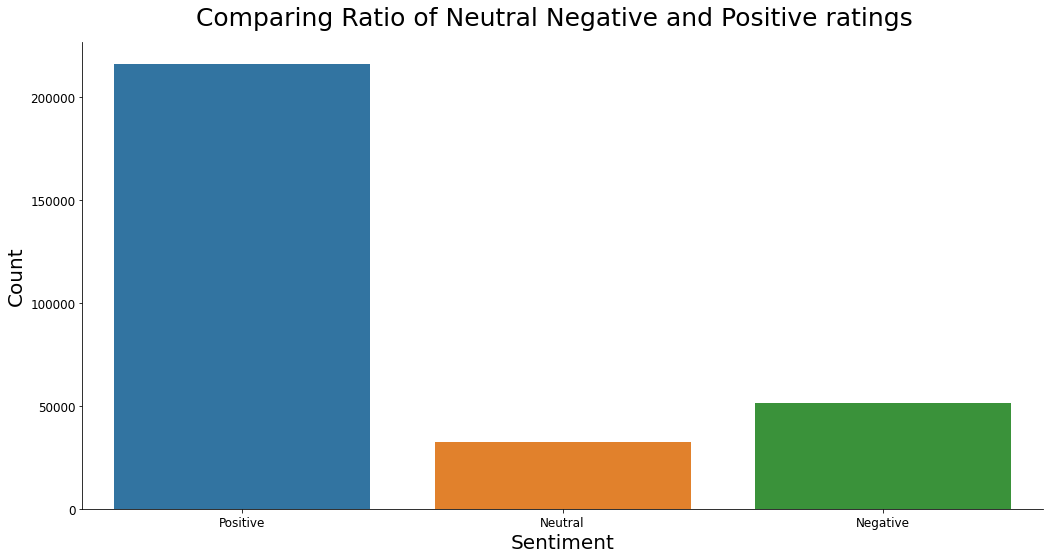

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

# Put features into dataframe
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "sentiment", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [ ]:
# Group by product and Rating class
df.groupby("product_id")["product_title"].unique()

product_id
B00RNT940S    [dagacci medical uniform womens scrub set stre...
B00RNT944O    [dagacci medical uniform womens scrub set stre...
B00RNT94SA    [dagacci medical uniform womens scrub set stre...
B00RNT94YY    [dagacci medical uniform womens scrub set stre...
B00RNT95PC    [dagacci medical uniform womens scrub set stre...
                                    ...                        
B01G6MBEBY    [jaeden womens beaded spaghetti straps sexy lo...
B01HDXFZK6    [belfry gangster  wool stainresistant crushabl...
B01I497BGY    [james fiallo mens pairs low cut athletic spor...
B01ID3ZS5W    [v women cowl neck knit stretchable elasticity...
B01KL6O72Y    [easy tool stainless steel fruit pineapple cor...
Name: product_title, Length: 182855, dtype: object

In [58]:
# Group by product and Rating class
df.groupby("product_title")["product_id"].count()

product_title
#03 Mystiqueshapes Multi-way Convertible Infinity Transformer Pencil Dress                            1
#04 Mystiqueshapes Multi-way Convertible Infinity Transformer Midi Dress                              1
#1 BEST Waist Trainer on Amazon - Hourglass Fashion Corset Weight Loss Cincher                       16
#1 Men’s Handkerchief Hankie 6 pc Set White Soft, Durable, Absorbent Organic Bamboo                   1
#906 - Hashtag Adult Men's T-Shirt, Black, X-Large                                                    1
                                                                                                     ..
zeroUV - Emerald Light Effects Geometric Prism Kaleidescope Glasses                                   7
zhao-king Sexy Nursing Maternity Camisole Tank Bra                                                    1
zhao-king® Seamless Push up Nursing and Maternity Bra Wireless Underwear                              1
“I Do What I Want” Purple Girls Toddler T-shirt wi

In [73]:
# Group by product and Rating class
df.groupby("product_title")["sentiment"].unique()

product_title
   mm snap on bullets black leather belt                                         [Negative]
   mm wide ladies wide boho disc concho leather belt                             [Positive]
  christian religious womens tshirt                                              [Positive]
  hashtag adult mens tshirt black large                                          [Positive]
  hashtag adult mens tshirt black xlarge                                         [Positive]
                                                                               ...         
zyxx madonna rebel heart classic act cotton t shirt for men black      [Positive, Negative]
zyxx madonna rebel heart tour  concert cotton t shirt for men black              [Positive]
zyxx madonna rebel heart tour  cotton t shirt for men black                      [Positive]
zzy cool dragon dragon tee  mens tshirt yellow size xxl                          [Positive]
zzy funny imagine dragons tank tops  womens tank top white        

#### Top Reviewed Product Name & Product ID


In [ ]:
# (4) Choose the label and features

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

Text(0.5, 1.0, 'Number of Reviews for Top 10 Products')

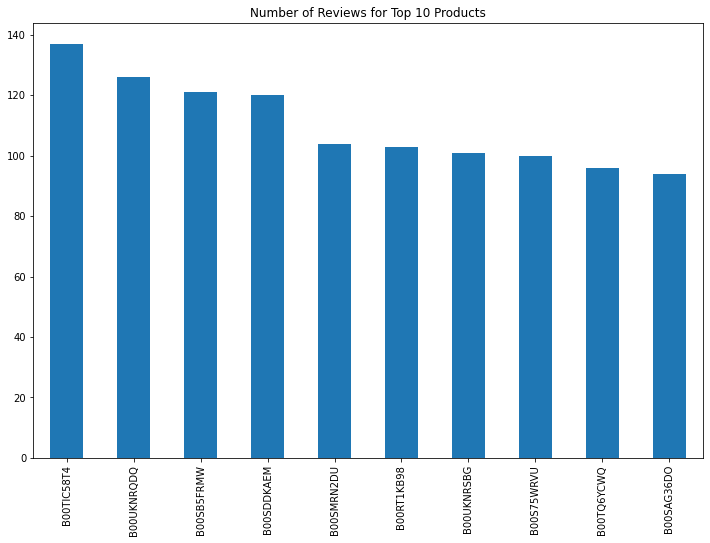

In [ ]:
# Plot number of reviews for top 10 products
products = df["product_id"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Products")

Text(0.5, 1.0, 'Number of Reviews for Top 10 Products')

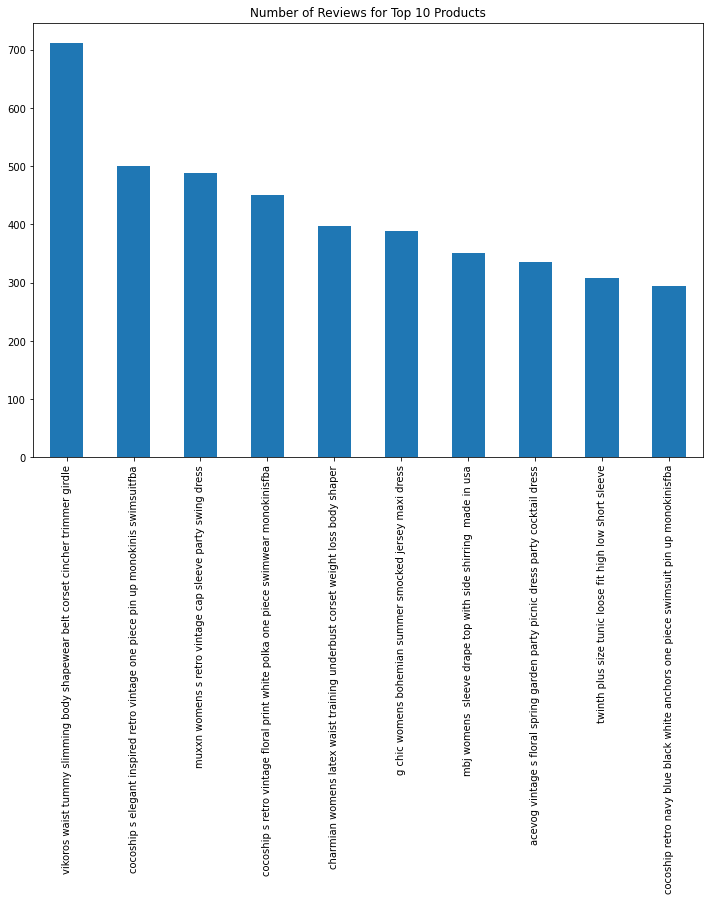

In [ ]:
# Plot number of reviews for top 10 products
products = df["product_title"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Products")

Text(0.5, 1.0, 'Number of Reviews for Top 10 Products')

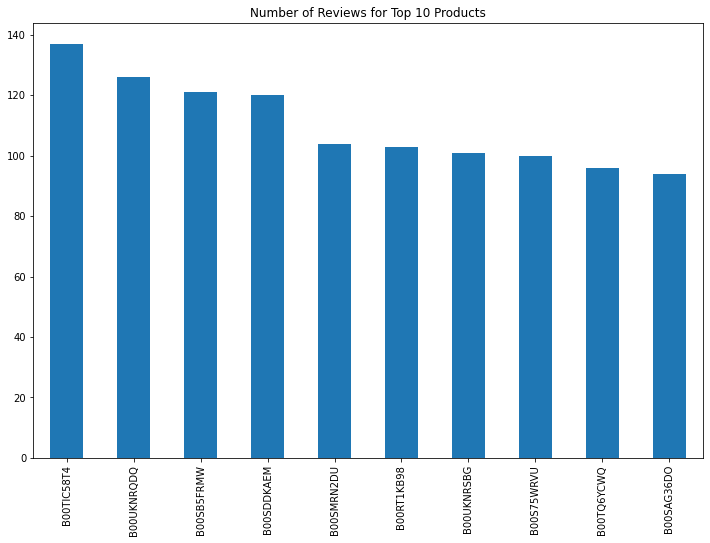

In [ ]:
# Plot number of reviews for top 10 products
products = df["product_id"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Products")

In [ ]:
different_names = df[df["product_id"] == 
                          "B00TIC58T4"]["product_title"].unique()
for name in different_names:
    print(name)

bluetime womens pleated short braces skirt fba


In [ ]:
different_names = df[df["product_title"] == 
                          "bluetime womens pleated short braces skirt fba"]["product_id"].unique()
for name in different_names:
    print(name)

B00ZC38F5M
B00ZC38ETY
B00ZC38ERG
B00TIC5BB4
B00TIC58T4


In [ ]:
different_names = df[df["product_title"] == 
                          "vikoros waist tummy slimming body shapewear belt corset cincher trimmer girdle"]["product_id"].unique()
for name in different_names:
    print(name)

B011KQKQL0
B00USW8O1W
B00USW8IAE
B00USW8DB8
B00USW878W
B00UKNS7SE
B00UKNS662
B00UKNS63A
B00UKNS41Y
B00UKNS3BK
B00UKNS234
B00UKNS1NA
B00UKNRZFK
B00UKNRZCS
B00UKNRX5C
B00UKNRX0M
B00UKNRUQY
B00UKNRUPA
B00UKNRSBG
B00UKNRS0W
B00UKNRQDQ
B00UKNRPYG
B00UKNRNVG
B00UKNRNMK


In [ ]:
df['product_title'].value_counts()

vikoros waist tummy slimming body shapewear belt corset cincher trimmer girdle       711
cocoship s elegant inspired retro vintage one piece pin up monokinis swimsuitfba     501
muxxn womens s retro vintage cap sleeve party swing dress                            488
cocoship s retro vintage floral print white polka one piece swimwear monokinisfba    450
charmian womens latex waist training underbust corset weight loss body shaper        398
                                                                                    ... 
bienvenu mens elastic waist casual quick drying athletic sports pants homewear         1
 fashion mlb houston astros diy tshirt for women custom tshirt                         1
cotton woodblock square head scarf tote bag set for cancer patients                    1
hater snapback jesus genesis snakeskin gold strapback silk feathers handmade           1
black skulls bucket hat w drawstring                                                   1
Name: product_title, 

In [ ]:
df['product_id'].value_counts()

B00TIC58T4    137
B00UKNRQDQ    126
B00SB5FRMW    121
B00SDDKAEM    120
B00SMRN2DU    104
             ... 
B00T4XLB8O      1
B00ZRT0KE0      1
B00U17UXUO      1
B00TICE606      1
B0131BKACC      1
Name: product_id, Length: 182855, dtype: int64

In [ ]:
df['product_id'].value_counts()

B00TIC58T4    137
B00UKNRQDQ    126
B00SB5FRMW    121
B00SDDKAEM    120
B00SMRN2DU    104
             ... 
B010J919HY      1
B00Y7KZJLY      1
B00U4BTDN0      1
B00XU0CEPG      1
B0131BKACC      1
Name: product_id, Length: 182913, dtype: int64

In [33]:
#Creating a copy
process_reviews=df[df["product_title"] == 
                          "vikoros waist tummy slimming body shapewear belt corset cincher trimmer girdle"].copy()

#Checking for null values
process_reviews.isnull().sum()

customer_id          0
product_id           0
product_parent       0
product_title        0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_body          0
review_date          0
sentiment            0
dtype: int64

In [ ]:
process_reviews.count()

customer_id          711
product_id           711
product_parent       711
product_title        711
star_rating          711
helpful_votes        711
total_votes          711
vine                 711
verified_purchase    711
review_body          711
review_date          711
sentiment            711
dtype: int64

#### Stemming the review

In [34]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [35]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['review_body','sentiment']].reset_index(drop=True)
review_features.head()

,review_body,sentiment
0,works love great product,Positive
1,five stars love,Positive
2,really love trainer but got size really love t...,Neutral
3,ok but nice mean price loosens pretty quickly ...,Negative
4,five stars accurate size chart,Positive


In [77]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['review_body'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)   

In [78]:
corpus[2]

'realli love trainer but got size realli love trainer but got size go get smaller size soon week'

In [37]:
positive_reviews = review_features[review_features.sentiment == "Positive"]
negative_reviews = review_features[review_features.sentiment == "Negative"]
neutral_reviews = review_features[review_features.sentiment == "Neutral"]

print("Good reviews shape: ",positive_reviews.shape)
print("Bad reviews shape: ", negative_reviews.shape)
print("Neutral reviews shape: ", neutral_reviews.shape)

Good reviews shape:  (451, 2)
Bad reviews shape:  (156, 2)
Neutral reviews shape:  (104, 2)


In [76]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
pos = review_features.loc[review_features['sentiment'] == 'Positive']
pos = pos[0:25000]

neg = review_features.loc[review_features['sentiment'] == 'Negative']
neg = neg[0:25000]

neu = review_features.loc[review_features['sentiment'] == 'Neutral']
neu = neg[0:25000]

In [40]:
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))
neu_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neu))

In [42]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

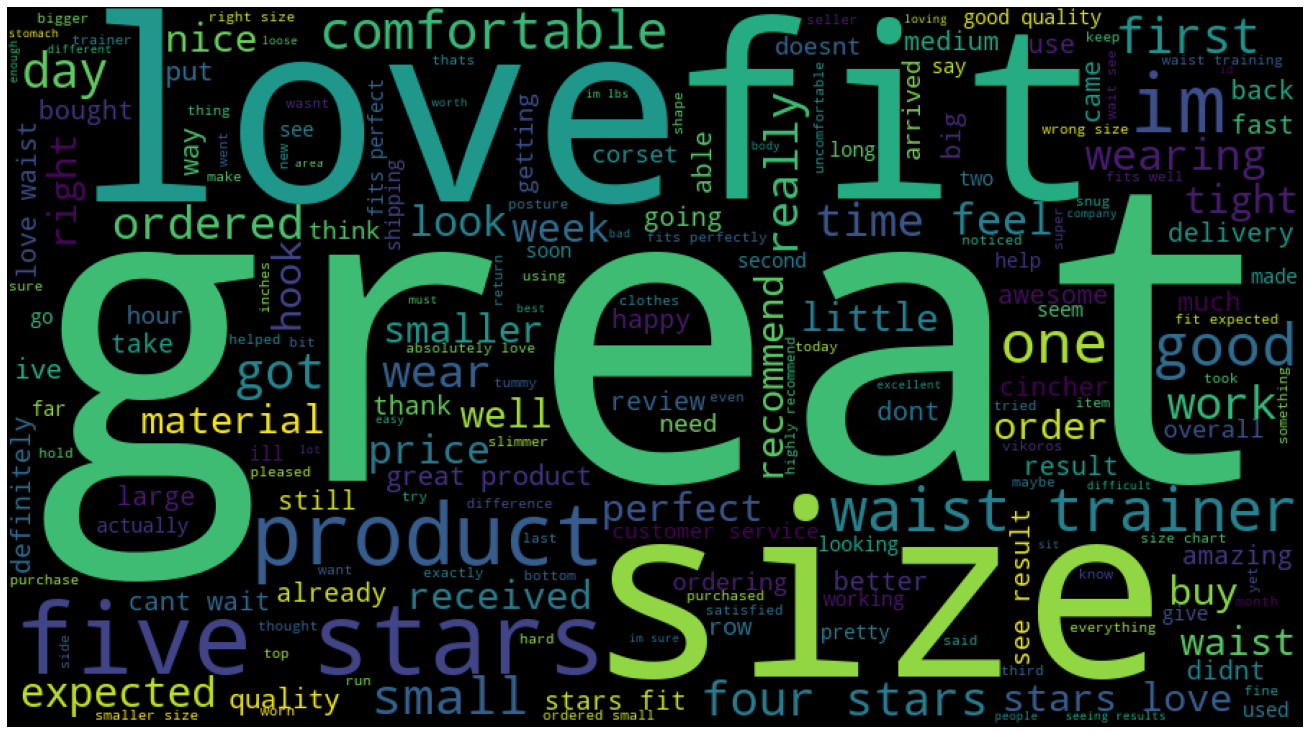

In [43]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

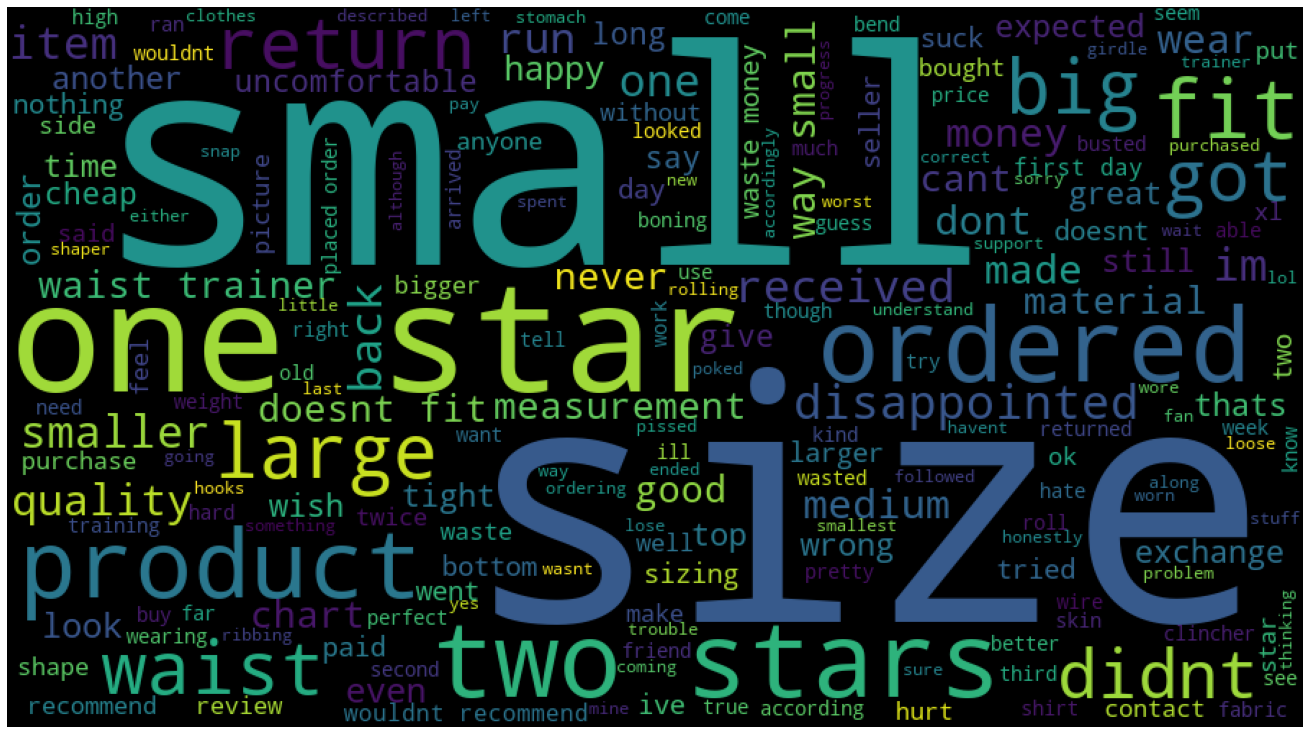

In [44]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

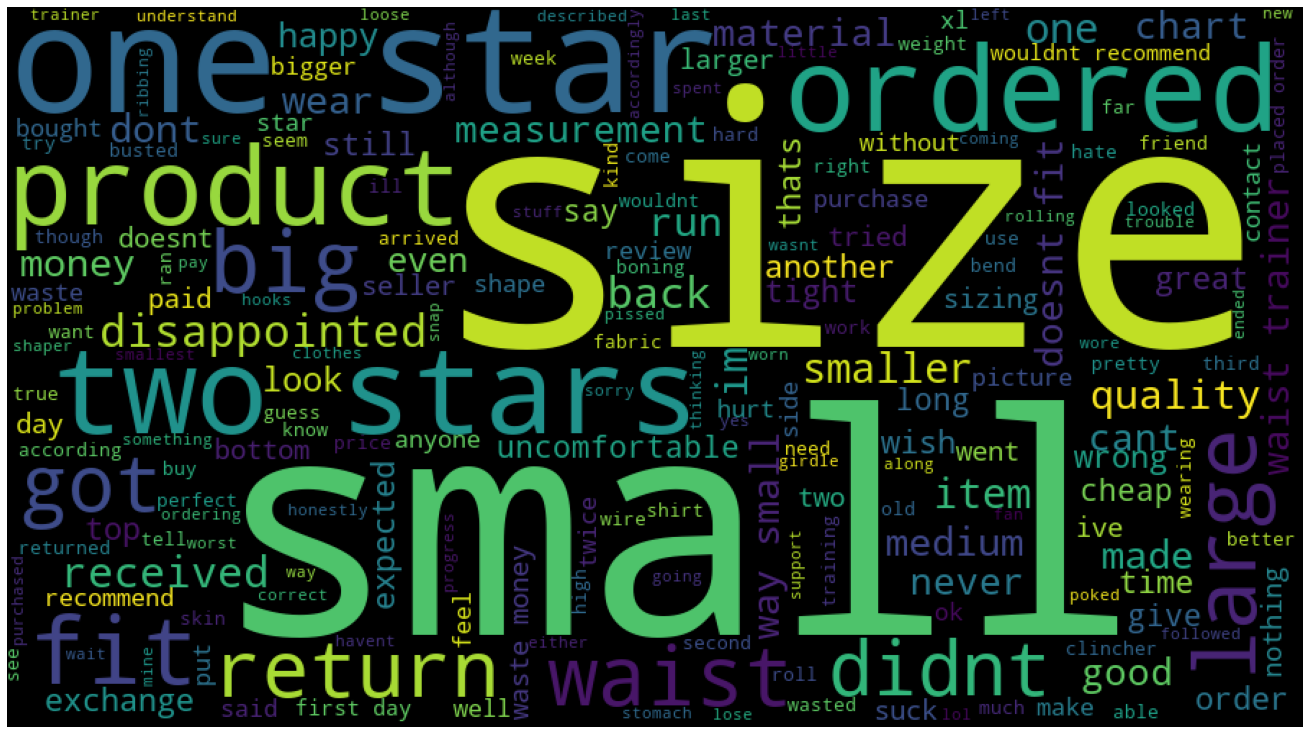

In [45]:
#Visuallizing popular neutral words
plot_Cloud(neu_wordcloud)

#### Word Count per review

In [ ]:
# Word Count per Review type
from textblob import TextBlob
df['text_word_count']= df.apply(lambda row: len(row['review_body']), axis=1)
# df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))


In [ ]:
df[df.star_rating==5].text_word_count.median()

82.0

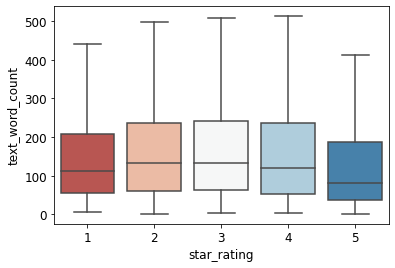

In [ ]:
sns.boxplot(x='star_rating',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

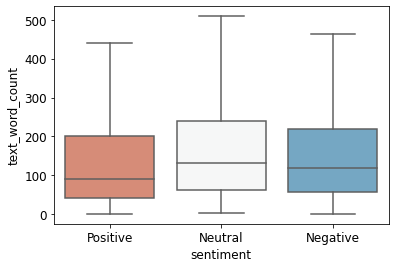

In [ ]:
sns.boxplot(x='sentiment',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [ ]:
# (6) Confirm data is ready with further exploratory analysis




*   Maximum reviews are positive
*   Product with Max reviews is Tummy slimming belt
*   This shows people mainly target losing weight :)
*   Postive reviews has lesser words compared to Neutral and negative. Neutral commets are ones with most words. Which can be critic comment or unsatisfied customers.





#### Popular words in Review

In [47]:
pos = df.loc[df['sentiment'] == 'Positive']
pos = pos[0:25000]

neg = df.loc[df['sentiment'] == 'Negative']
neg = neg[0:25000]

In [81]:
#Extracting 'reviews' for processing
review_all_features=df.copy()
review_all_features=review_all_features[['review_body','sentiment']].reset_index(drop=True)
review_all_features.head()

,review_body,sentiment
0,really work great tweaking really work great b...,Positive
1,favorite winter warm love dress absolute favor...,Positive
2,great socks money nice socks great colors enou...,Positive
3,slick hat bought husband wow slick hat high qu...,Positive
4,would perfect dress customer service awesome,Positive


In [83]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_all_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_all_features['review_body'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  

In [85]:
corpus[2]

'great sock money nice sock great color enough support wear good pair sneaker'

In [86]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
all_positive_reviews = review_all_features[review_all_features.sentiment == "Positive"]
all_negative_reviews = review_all_features[review_all_features.sentiment == "Negative"]
all_neutral_reviews = review_all_features[review_all_features.sentiment == "Neutral"]

print("Good reviews shape: ",all_positive_reviews.shape)
print("Bad reviews shape: ", all_negative_reviews.shape)
print("Neutral reviews shape: ", all_neutral_reviews.shape)

Good reviews shape:  (71148, 2)
Bad reviews shape:  (18400, 2)
Neutral reviews shape:  (10396, 2)


In [89]:
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))
neu_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neu))

In [92]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

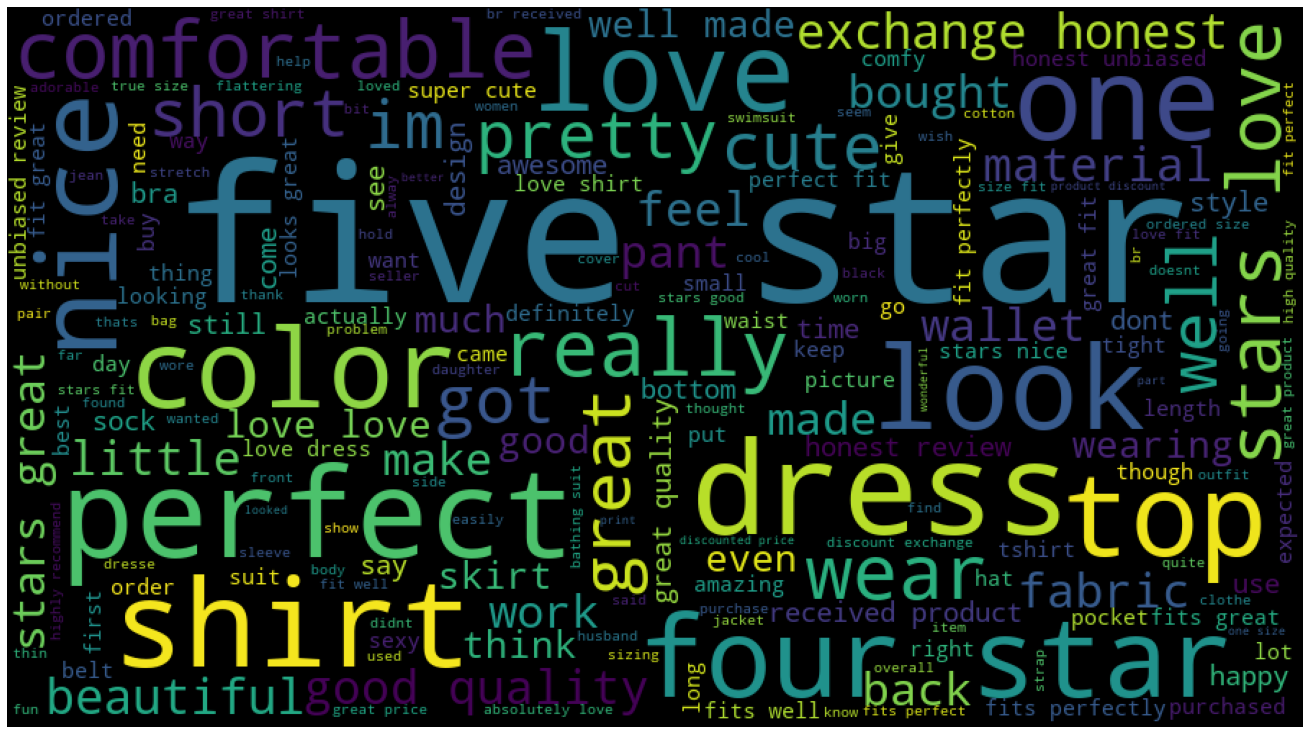

In [93]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

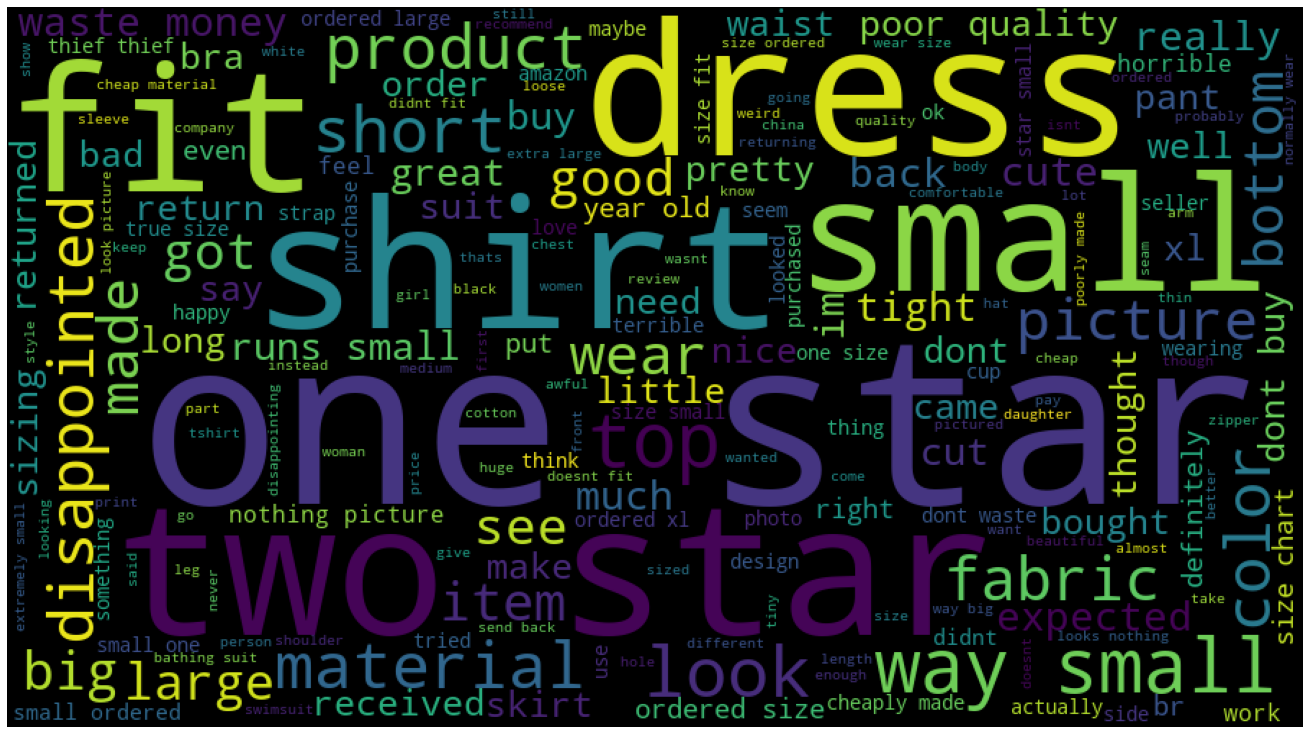

In [94]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

### Data Split, Machine Learning

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [ ]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [ ]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [ ]:
# (11) Use the model for prediction

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)

In [ ]:
df_cleaned = df.head(100000)
df_cleaned['star_rating'].count()
df_cleaned['star_rating'].unique()
df_cleaned['star_rating'].value_counts()
# indexNames = df_cleaned[ df_cleaned['star_rating'] == 'star_rating' ].index
# df_cleaned.drop(indexNames,inplace=True)
# df_cleaned.dropna(inplace=True)

5    53406
4    17786
1    11719
3    10402
2     6687
Name: star_rating, dtype: int64

In [ ]:
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
df_cleaned.head()

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,sentiment,text_word_count
0,32158956,B01KL6O72Y,24485154,easy tool stainless steel fruit pineapple core...,4,0,0,0,1,these really do work great with some tweaking...,2013-01-14,Positive,2824
1,2714559,B01ID3ZS5W,363128556,v women cowl neck knit stretchable elasticity ...,5,1,2,0,1,favorite for winter very warm i love this dres...,2014-03-04,Positive,368
2,12608825,B01I497BGY,811958549,james fiallo mens pairs low cut athletic sport...,5,0,0,0,1,great socks for the money nice socks great col...,2015-07-12,Positive,110
3,25482800,B01HDXFZK6,692205728,belfry gangster wool stainresistant crushable...,5,0,0,0,1,slick hat i bought this for my husband and wow...,2015-06-03,Positive,188
4,9310286,B01G6MBEBY,431150422,jaeden womens beaded spaghetti straps sexy lon...,5,0,0,0,1,i would do it again perfect dress and the cust...,2015-06-12,Positive,70


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df_cleaned['review_body'], df_cleaned['star_rating'], test_size=0.33, random_state=42)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

Accuracy on train 0.960373
Accuracy on test 0.788455


In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

Accuracy on train 0.778701
Accuracy on test 0.767727


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

Accuracy on train 0.999657
Accuracy on test 0.706182


In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

Accuracy on train 0.999582
Accuracy on test 0.686879


In [ ]:
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf',LinearSVC()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

Accuracy on train 0.884716
Accuracy on test 0.776303


#### Using KNN

In [ ]:
def partition(x):
    if x<3:
        return 'Negative'
    elif x>3:
        return 'Positive'
    return 'Neutral'

actualScore = df['star_rating']
positiveNegative = actualScore.map(partition)
df['Score'] = positiveNegative

In [ ]:
df['Time'] = df['review_date']
sortedData = df.sort_values('product_id',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"customer_id","Time","review_body"},keep="first",inplace=False)

final = final[final.helpful_votes >= final.total_votes-final.helpful_votes]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.008,random_state=2) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.1,random_state=1) #0.25

finalne = final[final.Score == 'Neutral']
finalne = finalne.sample(frac=0.02,random_state=4) #0.25

final = pd.concat([finalp,finaln, finalne],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [ ]:
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
all_neutral_words=[]
s=''

for sent in final['review_body'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    if(final['Score'].values)[i] == 'Neutral':
                        all_neutral_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [ ]:
from sklearn.model_selection import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=8)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [ ]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

In [ ]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

"""
df_test = pd.read_csv('test.csv')

df_test = df_test.dropna()

X_test = df_test['review_body']
y_test = df_test['ratings']

count_vect_test = CountVectorizer() 
final_bow_count_test = count_vect.fit_transform(X_test)
final_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)

X_test = final_bow_np_test
"""

"\ndf_test = pd.read_csv('test.csv')\n\ndf_test = df_test.dropna()\n\nX_test = df_test['review_body']\ny_test = df_test['ratings']\n\ncount_vect_test = CountVectorizer() \nfinal_bow_count_test = count_vect.fit_transform(X_test)\nfinal_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)\n\nX_test = final_bow_np_test\n"

In [ ]:
import numpy as np


The optimal number of neighbors is 13.
the misclassification error for each k value is :  [0.26  0.197 0.175 0.173 0.17  0.168 0.166]


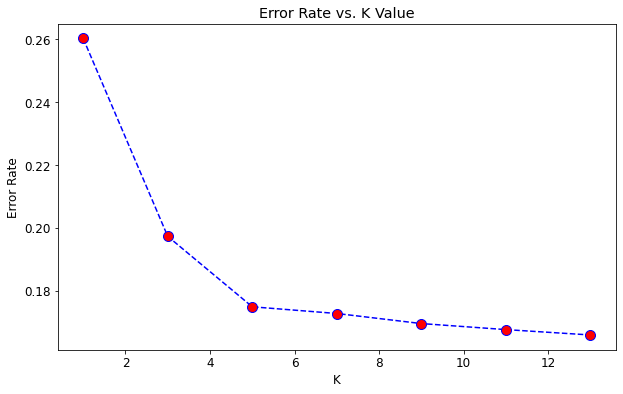

In [ ]:
myList = list(range(0,15))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=8)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [ ]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with Bag of words is  0.844


#### EDA by Spacy

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
stopwords = list(STOP_WORDS)

In [ ]:
import string
punctuations = string.punctuation
from spacy.lang.en import English
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#Custom Transformer using spaCy
class predictors(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self,deep=True):
        return{}
    
# Basic function to clean the text
def clean_text(text):
    return text.strip().lower()
tfdifVect = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from spacy import displacy

In [ ]:
# Breaking down a review into dependencies
doc = nlp(df['review_body'][8]) 
displacy.render(doc,style='dep',jupyter=True)

In [ ]:
#X = data.drop('star_rating',axis=1)
X = df['review_body']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

#### Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
y_train

92396     Positive
68447     Positive
930       Positive
295965     Neutral
74284     Positive
            ...   
119940    Positive
259304    Positive
131998    Positive
146940    Positive
122021    Positive
Name: sentiment, Length: 239883, dtype: object

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f30b576f410>),
                ('tfidfVect',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3157501680>)),
                ('classifier', LinearSVC())])

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
count = 1
for (sample,pred) in zip(X_test[0:10],sample_prediction[0:10]):
    print('\n',count,')')
    print(sample,"'PREDICTION':", pred)
    count += 1


 1 )
comforable skirt this is a very comfortable skirt with a fold over waistband i usually wear a size small or medium in this style so i ordered a medium because sometimes this style can be a little snug over my hips and the medium fits me perfectly im short  and the skirt comes to just past my knees a good length for wearing to work i love how light and soft the material is perfect for spring or summerbr br i received this product at a discount in exchange for my honest and unbiased review 'PREDICTION': Positive

 2 )
one accidentally rotten veggie these are so cute and super soft unfortunately the red tomato ran onto the rest of the onesie the others washed just fine because this was a registry item that someone else ordered for me i am having a hard time initiating a conversation with the seller im hoping that when i do finally get in touch with them theyll replaceexchange the one item of the three i hate to just do a return because the other two are so cute 'PREDICTION': Positiv

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

Accuracy: 0.8414400293475179


In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

array(['Negative'], dtype=object)

In [ ]:
pipe.predict(["Not great"])

array(['Positive'], dtype=object)

#### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier =  LogisticRegression()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f31574f6450>),
                ('tfidfVect',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3157501680>)),
                ('classifier', LogisticRegression())])

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

Accuracy: 0.8462756999216288


In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

array(['Negative'], dtype=object)

In [ ]:
pipe.predict(["Not great"])

array(['Positive'], dtype=object)

#### Decision Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f315b980310>),
                ('tfidfVect',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3157501680>)),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

Accuracy: 0.7842790682163046


In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

array(['Negative'], dtype=object)

In [ ]:
pipe.predict(["Not great"])

array(['Positive'], dtype=object)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f3157504410>),
                ('tfidfVect',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f3157501680>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

Accuracy: 0.8311350486068266


In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

array(['Negative'], dtype=object)

In [ ]:
pipe.predict(["Not good"])

array(['Positive'], dtype=object)

In [ ]:
pipe.predict(["Nice dress, good fitting"])

array(['Positive'], dtype=object)

In [ ]:
pipe.predict(["perfect size, good material"])

array(['Positive'], dtype=object)